# import dependancies

In [264]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


In [265]:
df = pd.read_csv('data/raw/dataset.csv')
df.columns

Index(['Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'CreditScoreBins'],
      dtype='object')

In [266]:
remainder_features = ['NumOfProducts','HasCrCard','IsActiveMember']
numerical_features=['Age','Tenure','Balance','EstimatedSalary']
nominal_features = ['Gender','Geography']
ordinal_features = ['CreditScoreBins']

In [267]:
numerical_transformer = Pipeline(
    steps=[
        ('imputer',SimpleImputer(strategy='median')),
        ('scaler',StandardScaler())
    ]
)

In [268]:
nominal_transformer = Pipeline(
    steps=[
        ('imputer',SimpleImputer(strategy='constant',
        fill_value='missing')),
        ('encoder',OneHotEncoder())
    ]
)

In [269]:
ordinal_transformer = Pipeline(
    steps=[
        ('imputer',SimpleImputer(strategy='constant',
        fill_value='missing')),
        ('encoder',OrdinalEncoder())
    ]
)

In [270]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num',numerical_transformer,numerical_features),
        ('nom',nominal_transformer,nominal_features),
        ('ord',ordinal_transformer,ordinal_features),
    ],
    remainder='drop'
)





In [271]:
nominal_feature_name = []

for feature in nominal_features:
    unique_values = df[feature].unique()
    nominal_feature_name.extend([f"{feature}_{val}" for val in unique_values])






In [272]:
df_cp = df.copy()


In [273]:
df_transformed = pd.DataFrame(
    preprocessor.fit_transform(df_cp),
    columns=numerical_features+nominal_feature_name+ordinal_features
)

df_remainder = df[remainder_features]


df_final = pd.concat(
    [df_transformed,df_remainder,df_cp.Exited],
    axis=1
)

df_final.head()



,Age,Tenure,Balance,EstimatedSalary,Gender_Female,Gender_Male,Geography_France,Geography_Spain,Geography_Germany,CreditScoreBins,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,0.428433,-1.041526,-1.225704,0.021852,1.0,0.0,1.0,0.0,0.0,1.0,1,1,1,1
1,0.332317,-1.387294,0.117331,0.216474,1.0,0.0,0.0,0.0,1.0,1.0,1,0,1,0
2,0.428433,1.033083,1.332886,0.240624,1.0,0.0,1.0,0.0,0.0,3.0,3,1,0,1
3,0.124038,-1.387294,-1.225704,-0.108935,1.0,0.0,1.0,0.0,0.0,2.0,2,0,0,0
4,0.522339,-1.041526,0.785627,-0.365260,1.0,0.0,0.0,0.0,1.0,0.0,1,1,1,0


In [274]:
df_final.to_csv('data/processed/x_transformed.csv')

## Handle Class Imbalance

1st split data, then make inbalance.

In [275]:
X = df_final.drop(columns=['Exited'])
Y = df_final['Exited']

In [276]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [277]:
# Convert to numpy arrays to avoid pandas compatibility issues
# Check class distribution before SMOTE
print("Original class distribution:")
print(Y_train.value_counts())

# Convert to numpy arrays for SMOTE compatibility
X_train_array = X_train.values
Y_train_array = Y_train.values

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_array, Y_train_array)

print("\nResampled class distribution:")
print(pd.Series(Y_train_resampled).value_counts())

Original class distribution:
Exited
0    6334
1    1660
Name: count, dtype: int64

Resampled class distribution:
0    6334
1    6334
Name: count, dtype: int64


Text(0.5, 1.0, 'TEST SET')

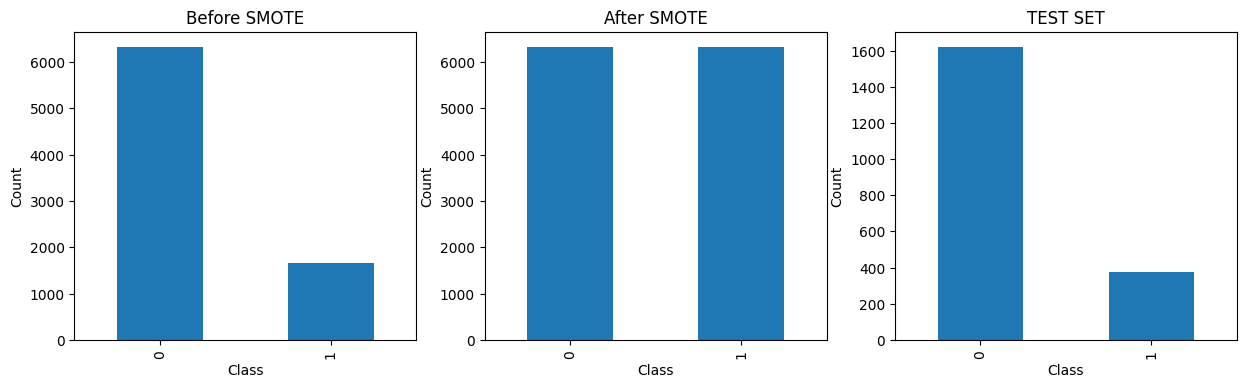

In [278]:
plt.figure(figsize=(15,4))

plt.subplot(131)
Y_train.value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('Class')
plt.title('Before SMOTE')

plt.subplot(132)
pd.Series(Y_train_resampled).value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('Class')
plt.title('After SMOTE')


plt.subplot(133)
Y_test.value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('Class')
plt.title('TEST SET')


In [279]:
# Convert resampled data back to DataFrames for easier handling
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)
Y_train_resampled_df = pd.Series(Y_train_resampled, name='Exited')

print(f"Original training set shape: {X_train.shape}")
print(f"Resampled training set shape: {X_train_resampled_df.shape}")
print(f"\nClass balance achieved: {(Y_train_resampled_df.value_counts()[1] / len(Y_train_resampled_df) * 100):.1f}% positive class")

Original training set shape: (7994, 13)
Resampled training set shape: (12668, 13)

Class balance achieved: 50.0% positive class


In [280]:
np.savez('artifacts/X_train.npz',X_train_resampled)
np.savez('artifacts/T_train.npz',Y_train_resampled)
np.savez('artifacts/X_test.npz',X_test)
np.savez('artifacts/Y_test.npz',Y_test)
